In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [2]:
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.RandomHorizontalFlip(0.4),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [3]:
batch_size = 4

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_len = int(len(train_dataset) * 0.8)
val_len = len(train_dataset) - train_len
trainset, valset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.batch_nor1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.batch_nor2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_nor1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_nor2(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
from torchsummary import summary
test_model = CNN()
summary(test_model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
       BatchNorm2d-2          [-1, 6, 220, 220]              12
         MaxPool2d-3          [-1, 6, 110, 110]               0
            Conv2d-4         [-1, 16, 106, 106]           2,416
       BatchNorm2d-5         [-1, 16, 106, 106]              32
         MaxPool2d-6           [-1, 16, 53, 53]               0
            Linear-7                  [-1, 120]       5,393,400
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 5,407,330
Trainable params: 5,407,330
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 8.07
Params size (MB): 20.63
Estimated Total Size (MB): 29.27
-------------------------------------

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

Epoch = 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


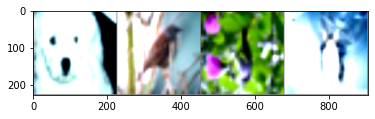

  dog  bird  bird   cat


In [7]:
import matplotlib.pyplot as plt
import torchvision

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [8]:
for epoch in range(Epoch):
    running_loss = 0.0
    running_corrects = 0.0

    val_loss = 0.0
    val_corrects = 0.0
    total = 0

    model.train()
    for idx, data in enumerate(train_loader):
      # get the input; data is a list of [inputs, labels]
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      # print statistics
      _, preds = torch.max(outputs, 1)
      running_loss += loss.item()
      running_corrects += torch.sum(preds == labels.data)
      if idx % 2000 == 1999:
        print('[Epoch: %d, %5d] loss: %.3f'%(epoch + 1, idx, running_loss / 2000))
        running_loss = 0.0
        running_corrects = 0.0
    
    # -------- Validation --------
    model.eval()
    with torch.no_grad():
      for idx, data in enumerate((val_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        predict = model(inputs)
        loss = criterion(predict, labels)

        _, vals = torch.max(predict, 1)
        val_loss += loss.item()
        val_corrects += (vals == labels).sum().item()
        total += labels.size(0)
    print('Validation [Epoch: %d, %5d] loss: %.3f'%(epoch + 1, idx, val_loss / total))
    print('Validation Acc: %.3f %%'%(val_corrects / total * 100))

    # -------- Schedule Learning Rate --------
    scheduler.step()
    print("Learning Rate: ", scheduler.get_last_lr()[0])

print('Finish Training')

# Saving model
model_path = './CNN_cifar_224.ckpt'
torch.save(model.state_dict(),model_path)

[Epoch: 1,  1999] loss: 2.021
[Epoch: 1,  3999] loss: 1.841
[Epoch: 1,  5999] loss: 1.760
[Epoch: 1,  7999] loss: 1.664
[Epoch: 1,  9999] loss: 1.609
Validation [Epoch: 1,  2499] loss: 0.384
Validation Acc: 44.690 %
Learning Rate:  0.00027
[Epoch: 2,  1999] loss: 1.562
[Epoch: 2,  3999] loss: 1.521
[Epoch: 2,  5999] loss: 1.496
[Epoch: 2,  7999] loss: 1.464
[Epoch: 2,  9999] loss: 1.453
Validation [Epoch: 2,  2499] loss: 0.348
Validation Acc: 49.680 %
Learning Rate:  0.000243
[Epoch: 3,  1999] loss: 1.424
[Epoch: 3,  3999] loss: 1.398
[Epoch: 3,  5999] loss: 1.380
[Epoch: 3,  7999] loss: 1.380
[Epoch: 3,  9999] loss: 1.378
Validation [Epoch: 3,  2499] loss: 0.344
Validation Acc: 50.390 %
Learning Rate:  0.0002187
[Epoch: 4,  1999] loss: 1.325
[Epoch: 4,  3999] loss: 1.340
[Epoch: 4,  5999] loss: 1.310
[Epoch: 4,  7999] loss: 1.307
[Epoch: 4,  9999] loss: 1.305
Validation [Epoch: 4,  2499] loss: 0.319
Validation Acc: 54.760 %
Learning Rate:  0.00019683
[Epoch: 5,  1999] loss: 1.260
[Epo

In [9]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# for confusion matrix
y_pred = []
y_true = []

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            y_pred.append(prediction.cpu().numpy())
            y_true.append(label.cpu().numpy())
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

Accuracy for class plane is: 70.9 %
Accuracy for class car   is: 67.1 %
Accuracy for class bird  is: 44.9 %
Accuracy for class cat   is: 45.9 %
Accuracy for class deer  is: 66.5 %
Accuracy for class dog   is: 48.4 %
Accuracy for class frog  is: 66.9 %
Accuracy for class horse is: 64.6 %
Accuracy for class ship  is: 70.4 %
Accuracy for class truck is: 69.8 %


# Reference  https://stackoverflow.com/questions/58589349/pytorch-confusion-matrix-plot

In [10]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.ylim(-0.5, len(classes) - 0.5)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.709 0.015 0.067 0.029 0.024 0.007 0.011 0.013 0.09  0.035]
 [0.052 0.671 0.022 0.018 0.01  0.011 0.015 0.014 0.066 0.121]
 [0.065 0.004 0.449 0.09  0.194 0.063 0.069 0.036 0.025 0.005]
 [0.023 0.008 0.076 0.459 0.109 0.175 0.06  0.052 0.021 0.017]
 [0.03  0.003 0.084 0.063 0.665 0.019 0.049 0.078 0.007 0.002]
 [0.019 0.009 0.063 0.225 0.083 0.484 0.026 0.071 0.012 0.008]
 [0.012 0.007 0.041 0.107 0.105 0.033 0.669 0.012 0.011 0.003]
 [0.02  0.005 0.028 0.064 0.121 0.077 0.012 0.646 0.014 0.013]
 [0.135 0.033 0.036 0.015 0.013 0.012 0.006 0.005 0.704 0.041]
 [0.053 0.087 0.015 0.038 0.021 0.011 0.011 0.026 0.04  0.698]]
[[709  15  67  29  24   7  11  13  90  35]
 [ 52 671  22  18  10  11  15  14  66 121]
 [ 65   4 449  90 194  63  69  36  25   5]
 [ 23   8  76 459 109 175  60  52  21  17]
 [ 30   3  84  63 665  19  49  78   7   2]
 [ 19   9  63 225  83 484  26  71  12   8]
 [ 12   7  41 107 105  33 669  12  11   3]
 [ 20   5  28  64 121  77  12 646  14  1

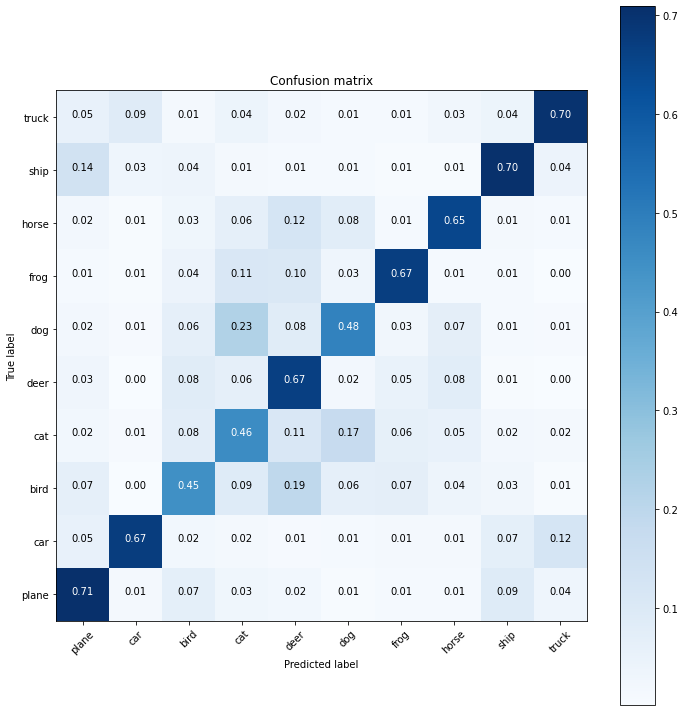

In [11]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cf_matrix, classes, normalize=True)
print(cf_matrix)

# Pre-trained Model

In [20]:
from efficientnet_pytorch import EfficientNet

pre_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10).to(device)
# pre_model.load_state_dict(torch.load('./CNN_cifar_224.ckpt'))

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(params=pre_model.parameters() ,lr=3e-4)

Loaded pretrained weights for efficientnet-b0


In [21]:
from tqdm import tqdm
for epoch in range(Epoch):
    running_loss = 0.0

    val_loss = 0.0
    val_corrects = 0.0
    total = 0

    pre_model.train()
    for idx, data in enumerate(tqdm(train_loader)):
      # get the input; data is a list of [inputs, labels]
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = pre_model(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      # print statistics
      _, preds = torch.max(outputs, 1)
      running_loss += loss.item()
      running_corrects += torch.sum(preds == labels.data)
      if idx % 1000 == 999:
        print('[Epoch: %d, %5d] loss: %.3f'%(epoch + 1, idx, running_loss / 1000))
        running_loss = 0.0
    
    # -------- Validation --------
    pre_model.eval()
    with torch.no_grad():
      for idx, data in enumerate((val_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        predict = pre_model(inputs)
        loss = criterion(predict, labels)

        _, vals = torch.max(predict, 1)
        val_loss += loss.item()
        val_corrects += (vals == labels).sum().item()
        total += labels.size(0)
    print('Validation [Epoch: %d, %5d] loss: %.3f'%(epoch + 1, idx, val_loss / total))
    print('Validation Acc: %.3f %%'%(val_corrects / total * 100))

print('Finish Training')

 10%|█         | 1003/10000 [01:05<09:18, 16.12it/s]

[Epoch: 1,   999] loss: 1.290


 20%|██        | 2001/10000 [02:13<09:52, 13.51it/s]

[Epoch: 1,  1999] loss: 0.978


 30%|███       | 3001/10000 [03:29<08:28, 13.76it/s]

[Epoch: 1,  2999] loss: 0.866


 40%|████      | 4001/10000 [04:42<07:20, 13.61it/s]

[Epoch: 1,  3999] loss: 0.795


 50%|█████     | 5001/10000 [05:56<06:06, 13.63it/s]

[Epoch: 1,  4999] loss: 0.720


 60%|██████    | 6001/10000 [07:08<04:42, 14.15it/s]

[Epoch: 1,  5999] loss: 0.699


 70%|███████   | 7001/10000 [08:19<03:35, 13.91it/s]

[Epoch: 1,  6999] loss: 0.667


 80%|████████  | 8000/10000 [17:26<27:41,  1.20it/s]

[Epoch: 1,  7999] loss: 0.634


 90%|█████████ | 9000/10000 [29:55<11:31,  1.45it/s]

[Epoch: 1,  8999] loss: 0.603


100%|█████████▉| 9999/10000 [38:35<00:00, 13.79it/s]

[Epoch: 1,  9999] loss: 0.624


100%|██████████| 10000/10000 [38:36<00:00,  4.32it/s]


Validation [Epoch: 1,  2499] loss: 0.109
Validation Acc: 85.830 %


 10%|█         | 1000/10000 [11:36<2:15:56,  1.10it/s]

[Epoch: 2,   999] loss: 0.512


 20%|██        | 2002/10000 [21:08<10:56, 12.18it/s]

[Epoch: 2,  1999] loss: 0.517


 30%|███       | 3002/10000 [22:19<08:18, 14.05it/s]

[Epoch: 2,  2999] loss: 0.506


 40%|████      | 4000/10000 [30:44<59:34,  1.68it/s]  

[Epoch: 2,  3999] loss: 0.503


 50%|█████     | 5001/10000 [39:04<05:27, 15.28it/s]

[Epoch: 2,  4999] loss: 0.514


 60%|██████    | 6001/10000 [40:10<04:22, 15.24it/s]

[Epoch: 2,  5999] loss: 0.476


 70%|███████   | 7003/10000 [41:13<03:07, 16.01it/s]

[Epoch: 2,  6999] loss: 0.498


 80%|████████  | 8001/10000 [42:16<02:13, 14.96it/s]

[Epoch: 2,  7999] loss: 0.482


 90%|█████████ | 9001/10000 [43:20<01:02, 16.11it/s]

[Epoch: 2,  8999] loss: 0.457


100%|█████████▉| 9999/10000 [44:24<00:00, 15.85it/s]

[Epoch: 2,  9999] loss: 0.451


100%|██████████| 10000/10000 [44:24<00:00,  3.75it/s]


Validation [Epoch: 2,  2499] loss: 0.090
Validation Acc: 89.100 %


 10%|█         | 1001/10000 [01:06<09:18, 16.11it/s]

[Epoch: 3,   999] loss: 0.410


 20%|██        | 2001/10000 [02:10<08:50, 15.08it/s]

[Epoch: 3,  1999] loss: 0.419


 30%|███       | 3001/10000 [03:18<08:21, 13.95it/s]

[Epoch: 3,  2999] loss: 0.434


 40%|████      | 4001/10000 [04:26<06:24, 15.62it/s]

[Epoch: 3,  3999] loss: 0.432


 50%|█████     | 5001/10000 [05:29<05:15, 15.83it/s]

[Epoch: 3,  4999] loss: 0.421


 60%|██████    | 6001/10000 [06:48<04:09, 16.02it/s]

[Epoch: 3,  5999] loss: 0.428


 70%|███████   | 7001/10000 [07:51<03:10, 15.72it/s]

[Epoch: 3,  6999] loss: 0.404


 80%|████████  | 8001/10000 [08:54<02:05, 15.96it/s]

[Epoch: 3,  7999] loss: 0.398


 80%|████████  | 8013/10000 [08:55<02:12, 14.96it/s]


KeyboardInterrupt: 

In [22]:
# Saving model
model_path = './Efficient_cifar_224.ckpt'
torch.save(pre_model.state_dict(),model_path)

In [23]:
# prepare to count predictions for each class
pre_correct_pred = {classname: 0 for classname in classes}
pre_total_pred = {classname: 0 for classname in classes}

pre_y_pred = []
pre_y_true = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = pre_model(images)
        _, predictions = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            pre_y_pred.append(prediction.cpu().numpy())
            pre_y_true.append(label.cpu().numpy())
            if label == prediction:
                pre_correct_pred[classes[label]] += 1
            pre_total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in pre_correct_pred.items():
    accuracy = 100 * float(correct_count) / pre_total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

Accuracy for class plane is: 90.4 %
Accuracy for class car   is: 90.2 %
Accuracy for class bird  is: 83.2 %
Accuracy for class cat   is: 81.9 %
Accuracy for class deer  is: 87.3 %
Accuracy for class dog   is: 62.3 %
Accuracy for class frog  is: 88.4 %
Accuracy for class horse is: 83.5 %
Accuracy for class ship  is: 91.5 %
Accuracy for class truck is: 85.5 %


Confusion matrix, without normalization
[[904   6  20  12  10   1   2   2  39   4]
 [ 11 902   4   5   0   1   2   0  45  30]
 [ 35   2 832  48  49  10  17   2   4   1]
 [  7   5  30 819  32  30  49   7  16   5]
 [  9   0  22  38 873   8  26  18   6   0]
 [  4   0  37 275  27 623  10  22   0   2]
 [  7   3  19  53  19   8 884   0   5   2]
 [ 13   1  15  49  68   8   7 835   0   4]
 [ 60   5   6   4   1   1   0   0 915   8]
 [ 20  64   3  11   0   0   2   1  44 855]]


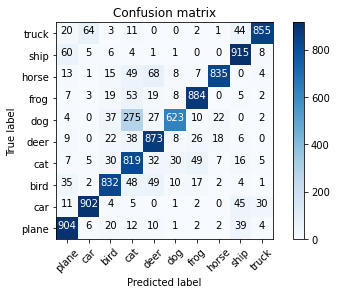

In [24]:
# Build confusion matrix
cf_matrix = confusion_matrix(pre_y_true, pre_y_pred)
plot_confusion_matrix(cf_matrix, classes)